# Add many "Section discharge" result specifications

This example shows how to add multiple "Section discharge" result specifications for 2D overland models. Basic workflow is:

1. Import section coordinates.
2. Create result specification for each section.
3. Add result specifications to a particular simulation ID.

#### Setup a dummy database to work with

In [1]:
from test_utils import create_sqlite_db
db_path = "my_model.sqlite"
create_sqlite_db(db_path)

#### Required imports

In [2]:
from mikeplus import DataTableAccess
from System import Nullable

# Note: GeoPandas and Contextily is not installed by default with MIKE+Py
import geopandas as gpd
import contextily as cx

#### 1. Import section coordinates.

In [3]:
# Read sections from shapefile into GeoDataFrame
gdf = gpd.read_file("../tests/testdata/notebooks/sections.shp")
gdf

,id,name,geometry
0,None,Section A,"LINESTRING (718491.472 6197313.657, 718488.758..."
1,None,Section B,"LINESTRING (718414.203 6197320.587, 718457.219..."
2,None,Section C,"LINESTRING (718346.568 6197339.455, 718355.316..."


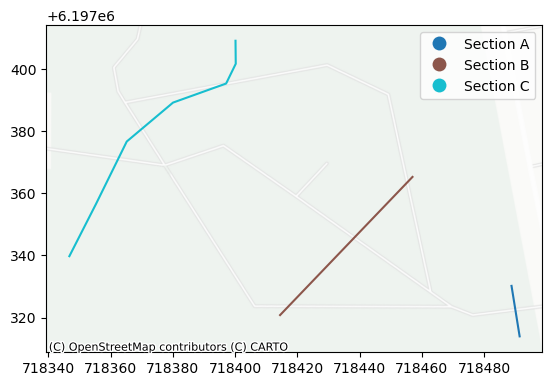

In [4]:
# Plot the sections
ax = gdf.plot(column='name', legend=True)
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.Positron)

In [5]:
# Create a dictionary with keys as section names and values as a list of xy coordinates of the section
sections_xy = {}
for name in gdf['name']:
    sections_xy[name] = list(gdf[gdf['name'] == name].geometry.values[0].coords)
print("Section A", sections_xy['Section A'])

Section A [(718491.4717670247, 6197313.657350091), (718488.7577802106, 6197330.542639723)]


#### 2. Create result specification for each section.

In [6]:
# Open the model database
dta = DataTableAccess(db_path)
dta.open_database()
dta

<DataTableContainer>
Db major version: 2024
Db minor version: 0.0
Active model: CS_MIKE1D
Unit system: MU_CS_SI
Active simulation: None

In [7]:
# Create one result specification per cross section with the appropriate types
for name in sections_xy:
    dta.insert("msm_RS", muid=name, values={
    "ModelTypeNo": Nullable[int](3),    # 3 = 2D Overland
    "ContentTypeNo": Nullable[int](21), # 21 = Section discharge
    "FormatNo": Nullable[int](2),       # 2 = Dfs0
})

In [8]:
# Insert the secion coordinates into the database. Note that coordinates must be in the same projection as the model.
table = dta.datatables["msm_RSSGeom"]
for name, xy in sections_xy.items():
    selection_id = dta.get_muid_where("msm_RSS", f"resultspecid=='{name}'")[0]
    for i, (x, y) in enumerate(xy):
        muid = table.CreateUniqueMuid()
        row = table.CreateRowData(muid)
        table.Insert(row)
        dta.set_values("msm_RSSGeom", muid, {"x":x, "y":y, "sqn":Nullable[int](i+1), "selectionid":selection_id})

#### 3. Add result specifications to a particular simulation ID.

In [9]:
# Create a new 2D overland simulation
simulation_id = "my_simulation"

row = dta.datatables["msm_Project"].CreateRowData(simulation_id)
dta.datatables["msm_Project"].Insert(row)

dta.set_values("msm_Project", simulation_id, {
    "Enable_2DOverland": Nullable[int](1),
    "Enable_HD": Nullable[int](1),
})

In [10]:
# Add all of the new result specifications to the simulation
for name in sections_xy:
    
    output_id = dta.datatables["msm_ProjectOutput"].CreateUniqueMuid()
    row = dta.datatables["msm_ProjectOutput"].CreateRowData(output_id)
    dta.datatables["msm_ProjectOutput"].Insert(row)

    dta.set_values("msm_ProjectOutput", output_id, {
        "outputid": name,
        "simulationid": simulation_id,
        "contentstypeno": Nullable[int](21), # 21 = Section discharge
        "FormatNo": Nullable[int](2),        # 2 = Dfs0
    })

In [11]:
# Close the database
dta.close_database()

#### Clean up

In [12]:
from pathlib import Path
db_path = Path(db_path)
for file in [db_path, db_path.with_suffix(".mupp")]:
    if file.exists():
        file.unlink()